In [37]:
import time 
import re
import os
import boto3
import json
import logging 

import numpy as np
import pandas as pd

from sagemaker.session import Session

# Image IO
from PIL import Image

# Morphological filtering
from skimage.morphology import opening
from skimage.morphology import disk

# Connected component filtering
import cv2

In [38]:
# # Amazon Textract client and Sagemaker session
# textract = boto3.client('textract')
# s3 = boto3.client('s3')
# session = Session()

# # initiate s3 bucket and corresponding data/output folder
# bucket = 'ran-s3-systemic-risk'

# data_png_folder = 'Input/X-17A-5-PNG-SUBSETS/'
# file_name = '1146184-2010-02-25-p4.png'
# sub_dir = '-'.join(file_name.split('.')[0].split('-')[:-1]) + '/'

# # retrieving downloaded files from s3 bucket
# s3.download_file(bucket, data_png_folder + sub_dir + file_name, 'original.png')

# Improving PNG Textract (was not super helpful)

In [39]:
# black = 0
# white = 255
# threshold = 160

# # Open input image in grayscale mode and get its pixels.
# img = Image.open("original.png").convert("LA")
# pixels = np.array(img)[:,:,0]

# # Remove pixels above threshold
# pixels[pixels > threshold] = white
# pixels[pixels < threshold] = black

# # Morphological opening
# blobSize = 1 # Select the maximum radius of the blobs you would like to remove
# structureElement = disk(blobSize)  # you can define different shapes, here we take a disk shape

# # We need to invert the image such that black is background and white foreground to perform the opening
# pixels = np.invert(opening(np.invert(pixels), structureElement))

# # Create and save new image.
# newImg = Image.fromarray(pixels).convert('RGB')
# newImg.save("new_image1.png")

# # Find the connected components (black objects in your image)
# # Because the function searches for white connected components on a black background, we need to invert the image
# nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(np.invert(pixels), connectivity=8)

# # For every connected component in your image, you can obtain the number of pixels from the stats variable in the last
# # column. We remove the first entry from sizes, because this is the entry of the background connected component
# sizes = stats[1:,-1]
# nb_components -= 1

# # Define the minimum size (number of pixels) a component should consist of
# minimum_size = 100

# # Create a new image
# newPixels = np.ones(pixels.shape)*255

# # Iterate over all components in the image, only keep the components larger than minimum size
# for i in range(1, nb_components):
#     if sizes[i] > minimum_size:
#         newPixels[output == i+1] = 0

# # Create and save new image.
# newImg = Image.fromarray(newPixels).convert('RGB')
# newImg.save("new_image2.png")

In [40]:
# for [jp, ms]
# if filing 2002-202, go and change derviates from 312, 332 # change

# Determing Firm Drops in Final Release

In [96]:
# read the structured database to determine all strucutred data fields 
asset_df = pd.read_csv('/home/ec2-user/SageMaker/SEC_X17A5/output/structured_asset.csv') 
liable_df = pd.read_csv('/home/ec2-user/SageMaker/SEC_X17A5/output/structured_liability.csv') 

In [97]:
# determing areas where totals not-found overlap
a = asset_df[asset_df['Total asset check'] == 'NOT FOUND'][['CIK', 'Filing Date']]
b = liable_df[liable_df["Total liabilities & shareholder's equity check"] == 'NOT FOUND'][['CIK', 'Filing Date']]

# recast to string to concate
a['CIK'] = a['CIK'].apply(str)
b['CIK'] = b['CIK'].apply(str)

# create a unique id
a['ID'] = a['CIK'] + '-' + a['Filing Date'] 
b['ID'] = b['CIK'] + '-' + b['Filing Date'] 

# shared ids between both asset and liability measures (we assume that both are missing due to firm reporting decision)
shared_ids = np.intersect1d(a['ID'].values, b['ID'].values)


In [103]:
shared_ids.size

38

In [98]:
# all of these have been approved as ok, they show no real issues as far as omission (all due to reporting standards)
a[~np.isin(a['ID'], shared_ids)]

,CIK,Filing Date,ID
5,1101180,2008-02-29,1101180-2008-02-29
358,803012,2005-01-03,803012-2005-01-03
359,803012,2006-01-03,803012-2006-01-03
360,803012,2007-01-29,803012-2007-01-29
361,803012,2008-12-30,803012-2008-12-30
362,803012,2009-12-29,803012-2009-12-29
363,803012,2010-12-27,803012-2010-12-27
364,803012,2011-12-21,803012-2011-12-21
365,803012,2012-01-30,803012-2012-01-30
538,895502,1998-11-13,895502-1998-11-13


In [99]:
# potential issues where final rows (total liabilites and shareholder equity is missing)
# since we have the presence of the counter, and the restructured totals we have 
b[~np.isin(b['ID'], shared_ids)]

,CIK,Filing Date,ID
15,1146184,2013-02-26,1146184-2013-02-26
127,26617,2002-05-30,26617-2002-05-30
228,42352,2021-02-25,42352-2021-02-25
274,68136,2008-01-31,68136-2008-01-31
483,87634,2006-02-28,87634-2006-02-28
553,89562,2002-01-29,89562-2002-01-29
554,89562,2003-01-29,89562-2003-01-29
555,89562,2004-01-29,89562-2004-01-29
556,89562,2005-01-31,89562-2005-01-31
557,89562,2006-01-30,89562-2006-01-30


In [100]:
# # re-naming columns with upper case convention 
# list(map(lambda x: '_'.join(x.upper().split(' ')), asset_df.columns))

In [101]:
# percent perfectly matched with the total asset figure
a = asset_df[asset_df['Total asset check'] == 'PERFECT MATCH'].shape[0] / asset_df.shape[0]

# percent matched with the total asset figure that is bounded by some delta
b = asset_df[asset_df['Total asset check'] == 'BOUNDED MATCH'].shape[0] / asset_df.shape[0]

# percent of errors that greatly differ from expected result 
c = asset_df[asset_df['Total asset check'] == 'GROSS MISMATCH'].shape[0] / asset_df.shape[0]

# percent of errors that are NaN 
d = asset_df[asset_df['Total asset check'] == 'NOT FOUND'].shape[0] / asset_df.shape[0]

print('PERCENT OF ERRORS (ASSET TABLE)')
print('-------------------------------')
print("""Percent of perfect match %.4f
Percent of bounded match %.4f
Percent of gross errors %.4f
Percent of NaNs %.4f

Percent of 'ok' values %.4f""" % (a, b, c, d, a+b))
print()

PERCENT OF ERRORS (ASSET TABLE)
-------------------------------
Percent of perfect match 0.8825
Percent of bounded match 0.0348
Percent of gross errors 0.0017
Percent of NaNs 0.0811

Percent of 'ok' values 0.9172



In [102]:
# percent perfectly matched with the total asset figure
a = liable_df[liable_df["Total liabilities & shareholder's equity check"] == 'PERFECT MATCH'].shape[0] / liable_df.shape[0]

# percent matched with the total asset figure that is bounded by some delta
b = liable_df[liable_df["Total liabilities & shareholder's equity check"] == 'BOUNDED MATCH'].shape[0] / liable_df.shape[0]

# percent of errors that greatly differ from expected result 
c = liable_df[liable_df["Total liabilities & shareholder's equity check"] == 'GROSS MISMATCH'].shape[0] / liable_df.shape[0]

# percent of errors that are NaN 
d = liable_df[liable_df["Total liabilities & shareholder's equity check"] == 'NOT FOUND'].shape[0] / liable_df.shape[0]

print('PERCENT OF ERRORS (LIABILITY & EQUITY TABLE)')
print('-------------------------------')
print("""Percent of perfect match %.4f
Percent of bounded match %.4f
Percent of gross errors %.4f
Percent of NaNs %.4f

Percent of 'ok' values %.4f""" % (a, b, c, d, a+b))

PERCENT OF ERRORS (LIABILITY & EQUITY TABLE)
-------------------------------
Percent of perfect match 0.8891
Percent of bounded match 0.0298
Percent of gross errors 0.0017
Percent of NaNs 0.0795

Percent of 'ok' values 0.9189


In [48]:
# read all CIK and Dealer name information from storage
with open('/home/ec2-user/SageMaker/SEC_X17A5/temp/ERROR-TEXTRACT.json', 'r') as f: textract_errors = json.loads(f.read())

In [49]:
# fixed '356628-1997-03-03' and '356628-1998-02-03' 
textract_errors

{'1101180-2007-03-02': 'No Balance Sheet found, or parsing error',
 '1146184-2005-03-02': 'No Balance Sheet found, or parsing error',
 '1146184-2010-03-09': 'No Balance Sheet found, or parsing error',
 '1261467-2020-03-02': 'No Balance Sheet found, or parsing error',
 '200565-2019-03-01': 'No Balance Sheet found, or parsing error',
 '318336-2010-03-01': 'No Balance Sheet found, or parsing error',
 '42352-2010-03-03': 'No Balance Sheet found, or parsing error',
 '42352-2020-02-28': 'No Balance Sheet found, or parsing error',
 '48966-2010-03-02': 'No Balance Sheet found, or parsing error',
 '68136-2009-02-10': 'No Balance Sheet found, or parsing error',
 '68136-2020-03-02': 'No Balance Sheet found, or parsing error',
 '753835-2021-03-15': 'No Balance Sheet found, or parsing error',
 '754542-2009-03-02': 'No Balance Sheet found, or parsing error',
 '782124-2010-03-02': 'No Balance Sheet found, or parsing error',
 '874362-2010-03-02': 'No Balance Sheet found, or parsing error',
 '890203-20

## Determining the most important firms

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress

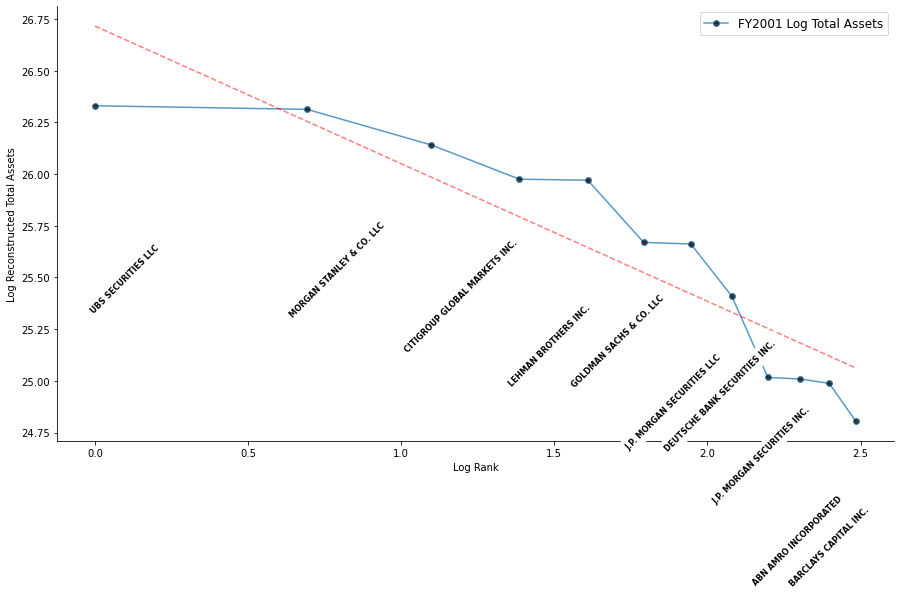

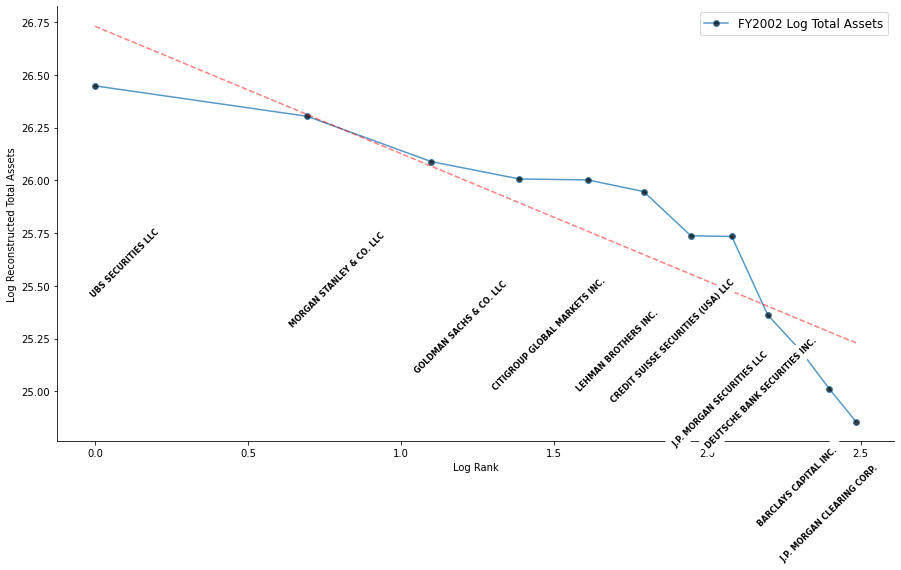

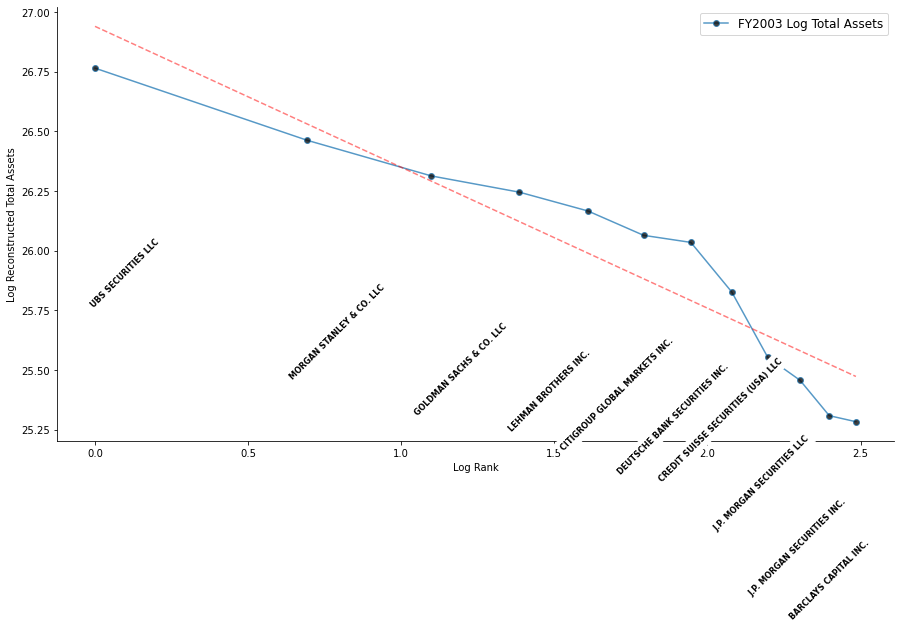

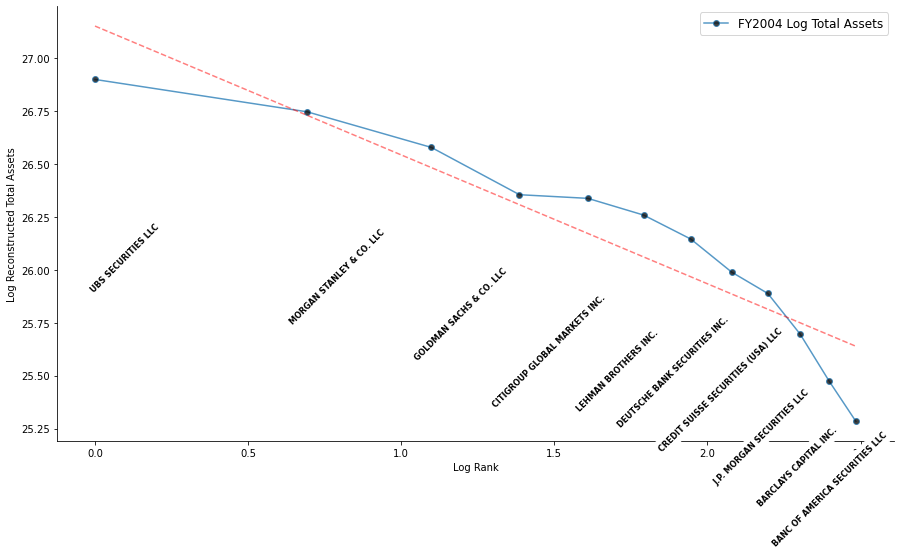

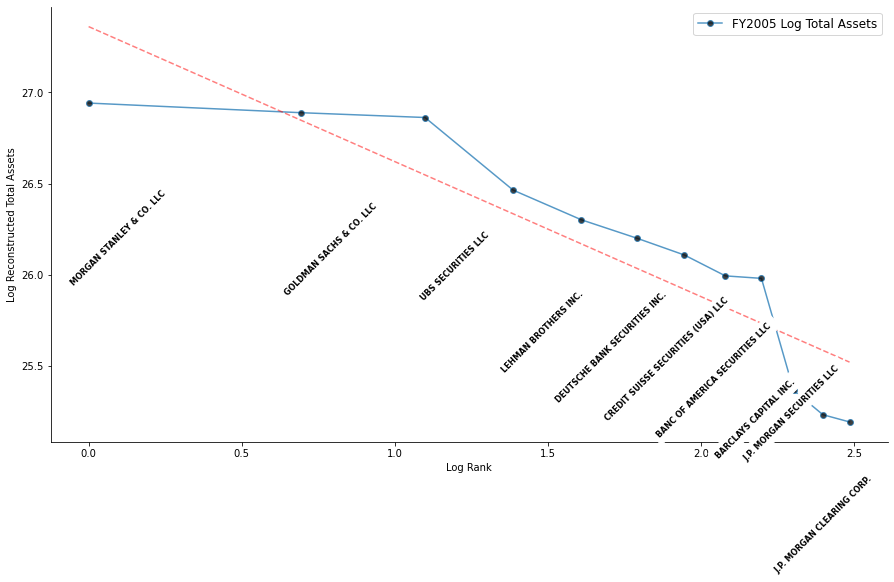

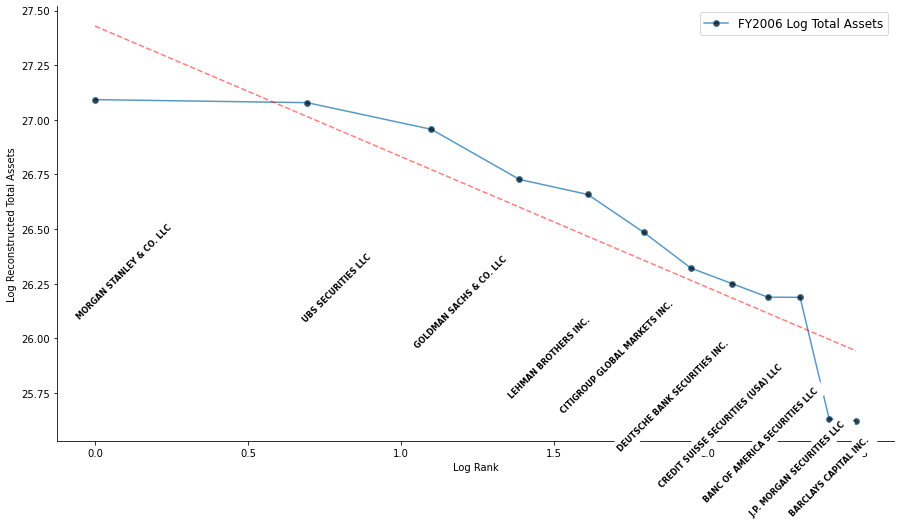

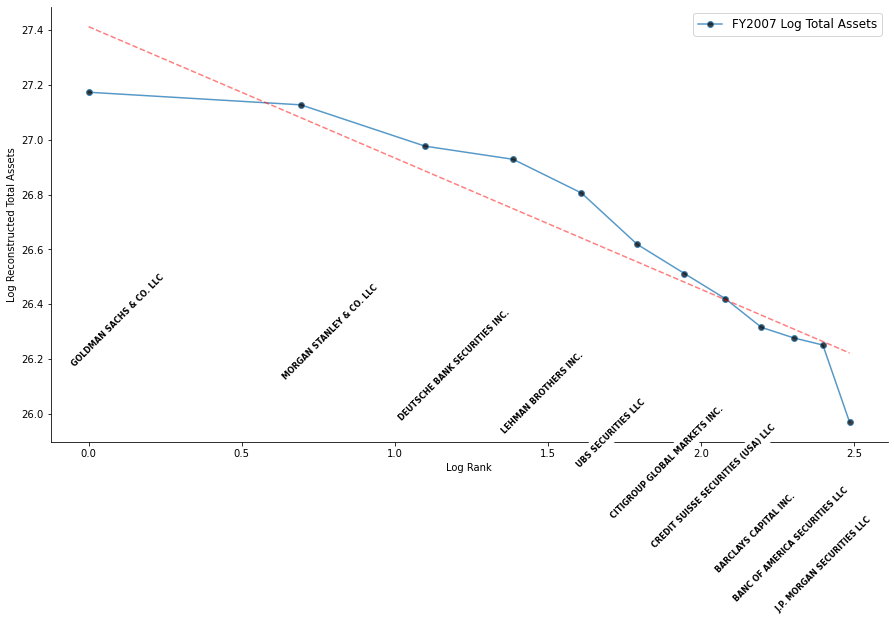

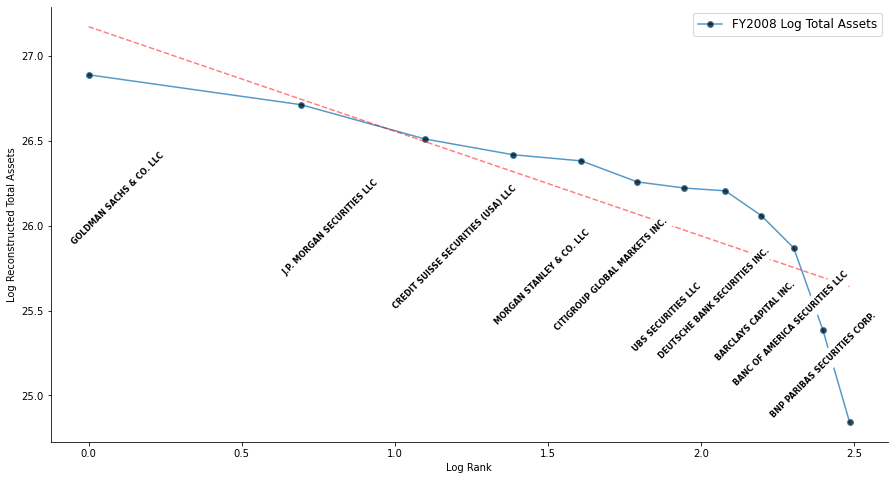

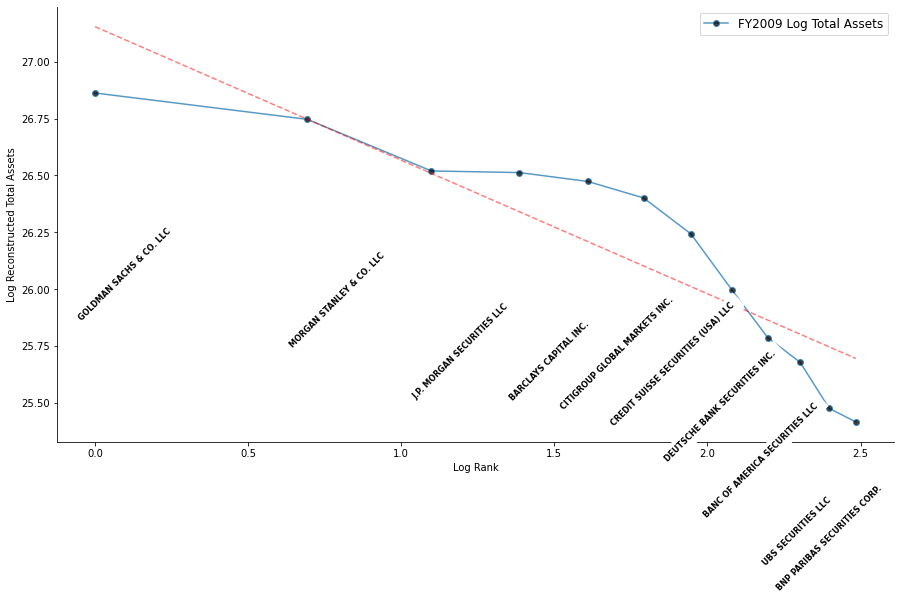

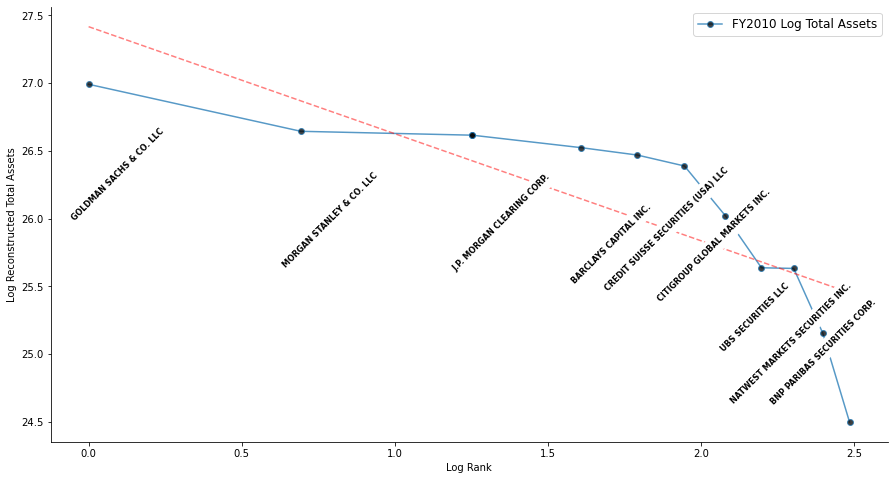

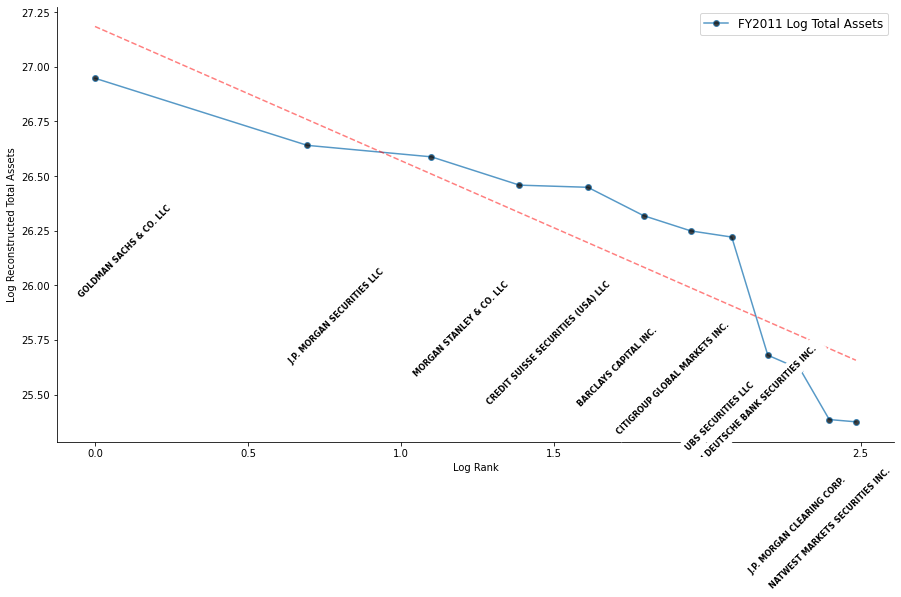

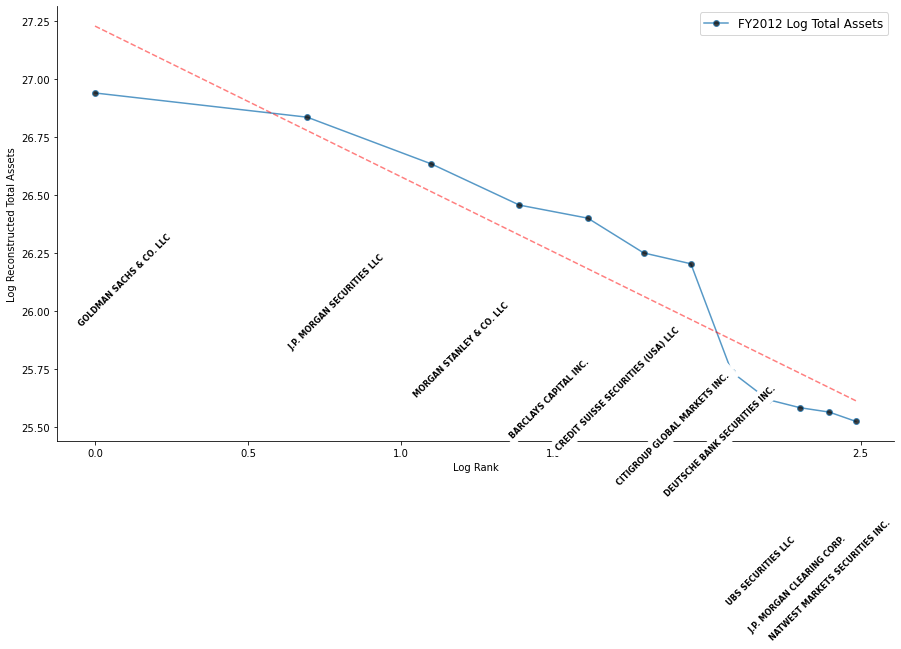

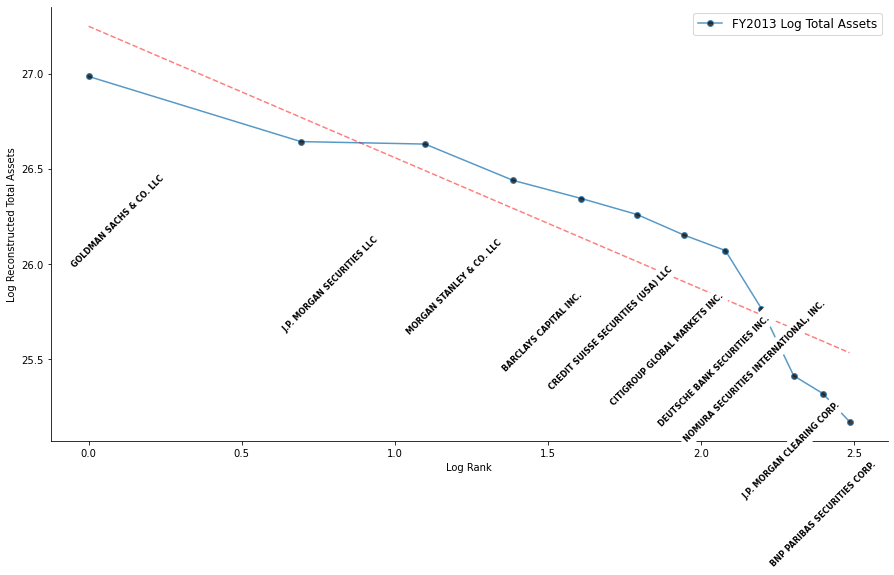

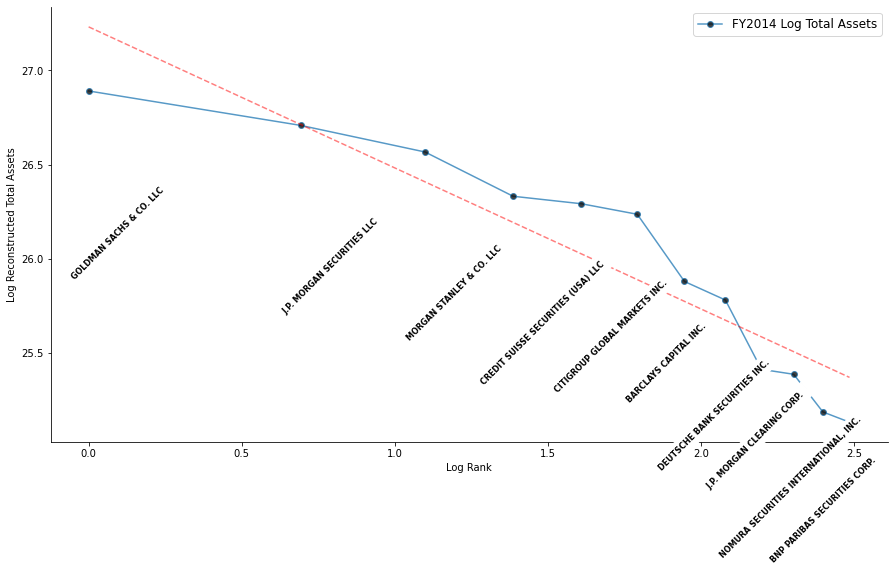

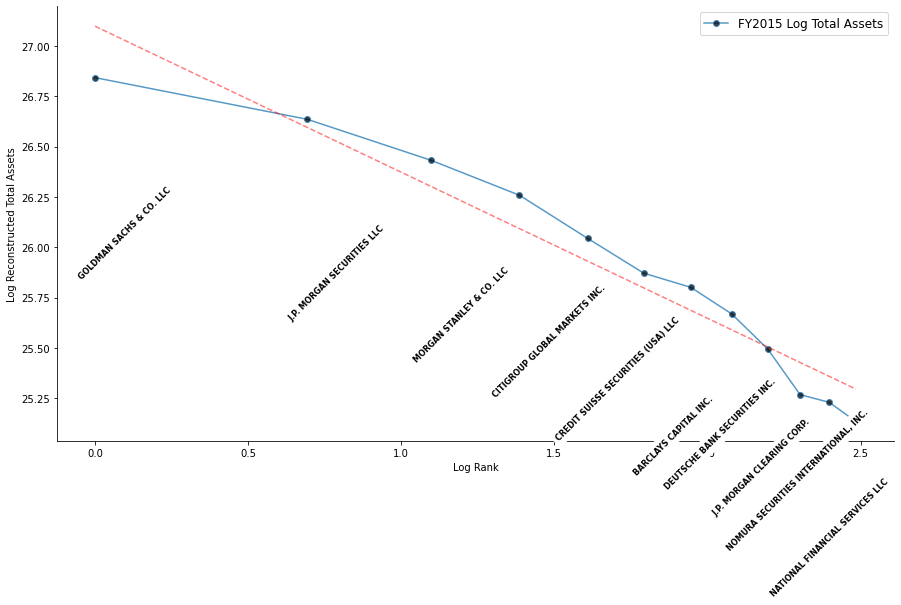

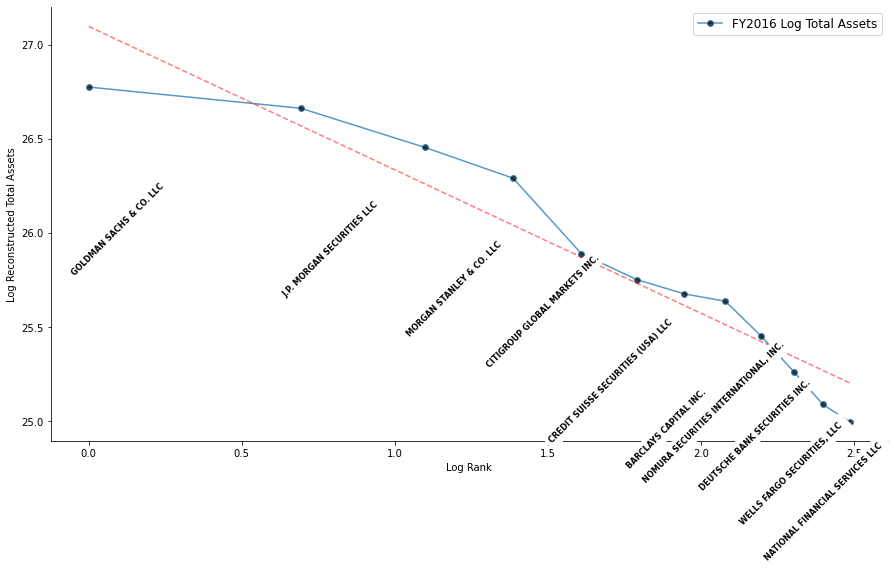

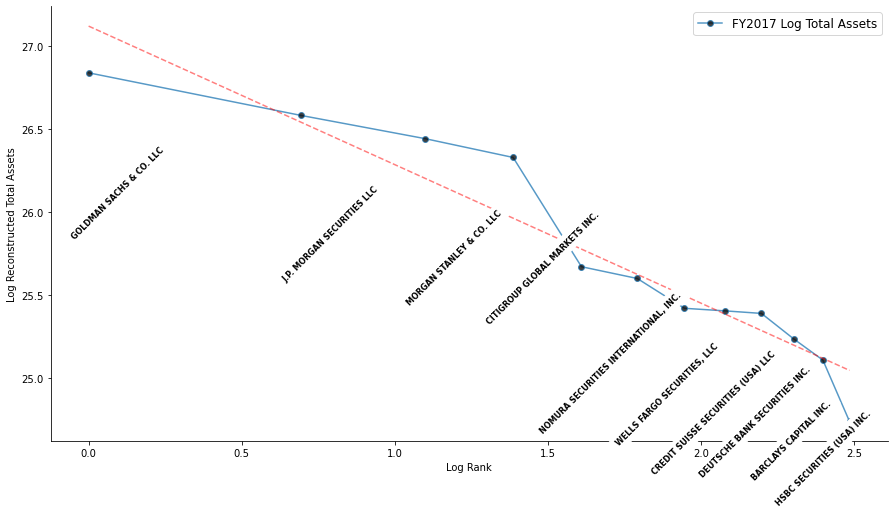

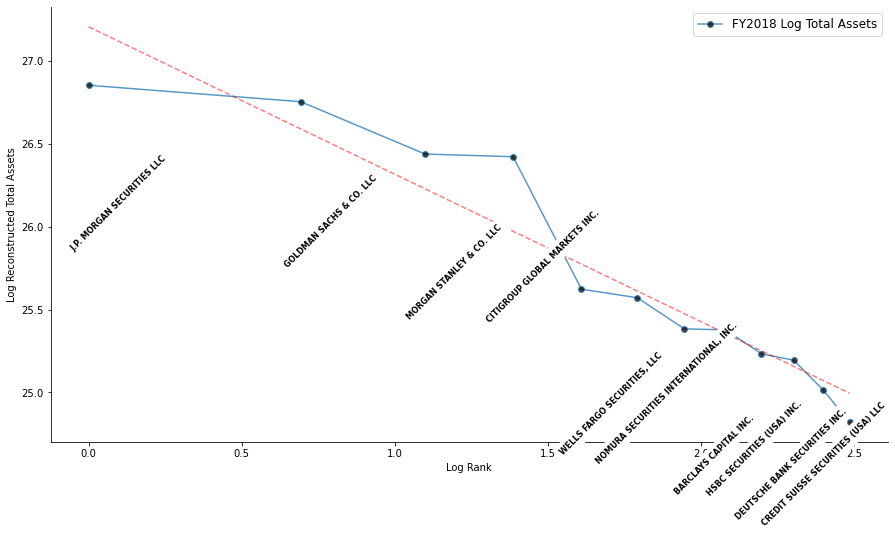

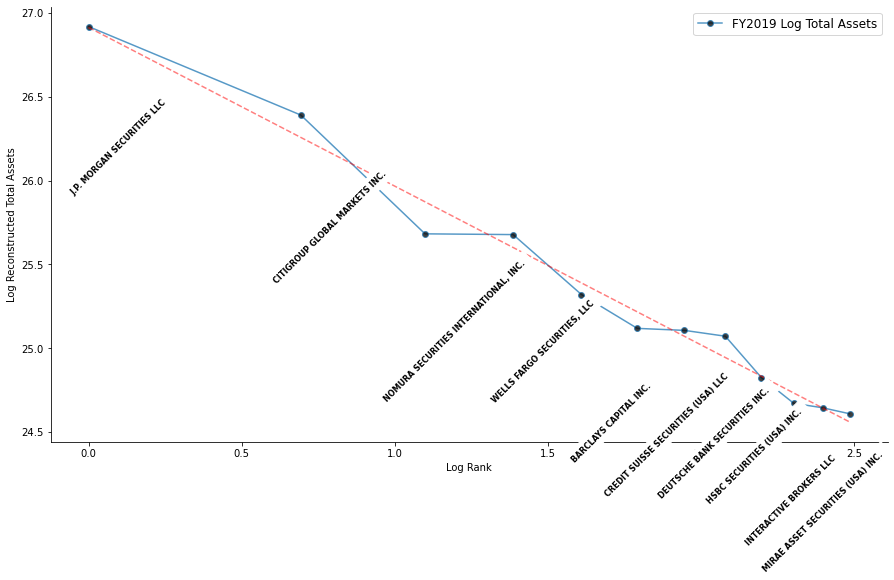

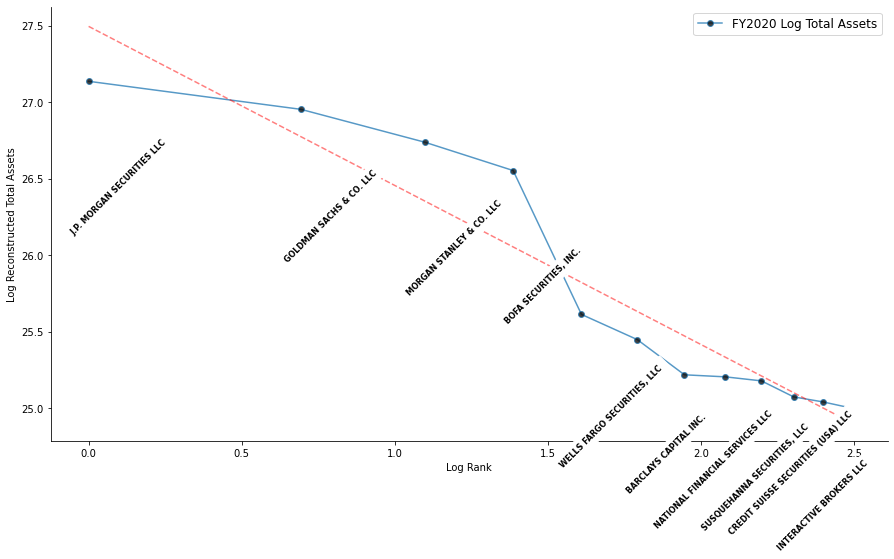

In [105]:
# iterate through each of the filing years to determine the largest banks across each space
filing_years = np.arange(2000, 2021, 1)
corresponding_slopes = []
top10_bank_assets = []

for y in filing_years:
    filter_series = asset_df[asset_df['Filing Year'] == y]
    
    if not filter_series.empty:
        orderd_series = filter_series[['Name', 'Reconstructed Total assets']].sort_values(by='Reconstructed Total assets', 
                                                                                          ascending=False)

        # compute the rank of the "reconstructed" total assets figure for a particular year
        orderd_series['Rank'] = orderd_series['Reconstructed Total assets'].rank(ascending=False)

        # scale total assets and rank with log
        orderd_series[['Reconstructed Total assets', 'Rank']] = orderd_series[['Reconstructed Total assets', 
                                                                               'Rank']].apply(np.log)
        
        # special filter for rank cutoff apporoximation
        orderd_series = orderd_series[orderd_series.Rank < 2.5]

        # --------------------------------------------------------------------------------------------------------
        # perform baseline linear regression to define cutoffs and highlight top 10 broker-dealers
        fig, ax = plt.subplots()

        fig.set_figheight(8)
        fig.set_figwidth(15)

        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

        m = linregress(orderd_series.Rank, orderd_series['Reconstructed Total assets'])
        corresponding_slopes.append((y, m))
        
        ax.plot(orderd_series.Rank, orderd_series['Reconstructed Total assets'], 
                label='FY' + str(y) + ' Log Total Assets',  marker='o', markerfacecolor='k', alpha=0.75)
        ax.plot(orderd_series.Rank, orderd_series.Rank*m.slope + m.intercept, ls='--', c='r', alpha=0.5)

        ax.set_ylabel('Log Reconstructed Total Assets')
        ax.set_xlabel('Log Rank')

        # top ten broker-dealer firms for every year
        naming_schemes = orderd_series.iloc[:10].Name.values
        value_schemes = orderd_series.iloc[:10]['Reconstructed Total assets'].values
        rank_schemes = orderd_series.iloc[:10].Rank.values
        
        top10_bank_assets.append((y, sum(np.exp(value_schemes))))
        
        for i, v in enumerate(naming_schemes):
            ax.text(rank_schemes[i]+0.1, value_schemes[i]-1, "%s" %v, ha='center', rotation=45, 
                    fontsize=8, fontweight='bold', backgroundcolor='white')

        ax.legend(prop={'size': 12})
        # --------------------------------------------------------------------------------------------------------

        plt.show()

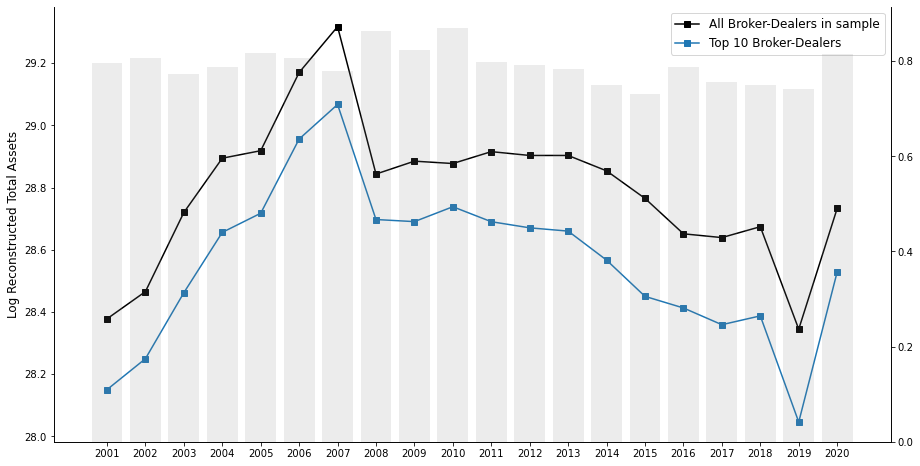

In [86]:
# analyzing the distribution of total assets over the entire sample
fig, ax = plt.subplots()

fig.set_figheight(8)
fig.set_figwidth(15)

# ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

x1 = np.array(list(map(lambda x: x[0], top10_bank_assets)))         # extracting years and slopes
x2 = np.array(list(map(lambda x: x[1], top10_bank_assets)))

# we need to check the values of 2013 (something is very wrong here maybe a scaler issue)
X = asset_df.groupby('Filing Year')['Reconstructed Total assets'].sum()

ax.plot(X.index[1:], np.log(X.values[1:]), marker='s', color='k', label='All Broker-Dealers in sample')
ax.plot(x1, np.log(x2), marker='s', label='Top 10 Broker-Dealers')

ax.set_ylabel('Log Reconstructed Total Assets', size=12)
ax.set_xticks(X.index[1:])
ax.legend(prop={'size': 12})

ax2 = ax.twinx()
ax2.spines['top'].set_visible(False)
ax2.bar(x1, x2 / X.values[1:], alpha=0.15, color='grey')

plt.show()

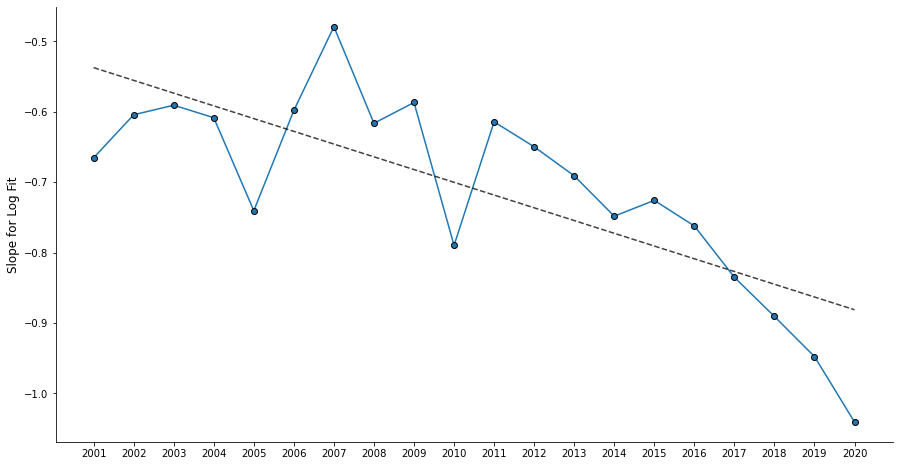

In [106]:
# observing the slope over time for the simple OLS over log total assets
# we see that over time the slope has grown flatter, potentially a sign of industry consolidation

x1 = np.array(list(map(lambda x: x[0], corresponding_slopes)))         # extracting years and slopes
x2 = np.array(list(map(lambda x: x[1].slope, corresponding_slopes)))

# analyzing the distribution of total assets over the entire sample
fig, ax = plt.subplots()

fig.set_figheight(8)
fig.set_figwidth(15)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

m = linregress(x1, x2)   # perform simple OLS

# we plot the time series of the slope of the 
ax.plot(x1, x2, marker='o', markeredgecolor='k')
ax.plot(x1, x1*m.slope + m.intercept, ls='--', c='k', alpha=0.75)
ax.set_xticks(x1)

ax.set_ylabel('Slope for Log Fit', size=12)
# erp + fixed effect + regulatory/efficiency
plt.show()

In [112]:
asset_df[np.isin(asset_df.Name, orderd_series.Name.iloc[:5].values)].CIK.unique()

array([1224385, 1675365,  276523,   42352,   68136,  782124])